<a href="https://colab.research.google.com/github/Barabaika/rna-cite-compit2022/blob/scMVP/cite_3_inps_cnn_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install colorama
!pip install tensorflow-addons
!pip install keras-tuner
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from colorama import Fore, Back, Style

from sklearn.model_selection import KFold,GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
# from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, LayerNormalization, Layer, MultiHeadAttention, Reshape, Attention, Conv1D, \
    MaxPool1D, Dropout, BatchNormalization, Flatten, AveragePooling1D, Multiply

from tensorflow_addons.layers import WeightNormalization, AdaptiveAveragePooling1D

from tensorflow.keras.utils import plot_model
import keras_tuner
from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import minmax_scale

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 10.6 MB/s 
     |████████████████████████████████| 1.6 MB 47.5 MB/s 


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

!mkdir /root/.kaggle
!cp /content/gdrive/MyDrive/kaggle/kaggle.json /root/.kaggle


!mkdir data
!unzip /content/gdrive/MyDrive/kaggle/metadata.csv.zip -d data
!unzip /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip -d data

!kaggle datasets download -d geraseva/target-genes-denoised
!kaggle datasets download -d geraseva/cite-inputs-dca-pca
!kaggle datasets download -d grac2h5/top-100-closest-to-target-genes-with-features

!unzip -q target-genes-denoised.zip -d data
!unzip -q cite-inputs-dca-pca.zip -d data
!unzip -q top-100-closest-to-target-genes-with-features -d data

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/kaggle/metadata.csv.zip
  inflating: data/metadata.csv       
Archive:  /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip
  inflating: data/train_cite_targets.h5  
100% 643M/645M [00:35<00:00, 22.4MB/s]
100% 645M/645M [00:35<00:00, 19.3MB/s]
 96% 102M/106M [00:06<00:00, 22.0MB/s] 

In [ ]:
DATA_DIR = "/content/data"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")

TUNE = False
SUBMIT = True

In [ ]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def std(x):
    return (x - np.mean(x)) / np.std(x)

In [ ]:
X_imp_genes = pd.read_csv('/content/data/citeseq_target_genes_denoised_dca.csv')
X_imp_genes = X_imp_genes.set_index('cell_id')

X_train_imp_genes = X_imp_genes.iloc[:70988, :].values
X_test_imp_genes = X_imp_genes.iloc[70988:, :].values

assert X_test_imp_genes.shape[0] == 48663

meta = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
meta = meta.reindex(X_imp_genes.iloc[:70988, :].index)
print(meta.shape)

del X_imp_genes
gc.collect()

In [ ]:
X_dim_red = pd.read_csv('/content/data/cite_inputs_dca_denoised_PCA200.csv')
X_dim_red = X_dim_red.drop('Unnamed: 0', axis = 1)

X_train_dim_red = X_dim_red.iloc[:70988, :].values
X_test_dim_red = X_dim_red.iloc[70988:, :].values

del X_dim_red
gc.collect()

In [ ]:
#loading data from Antom (top 100 closest to tagret genes with features)
top100_folder = 'mean_by_target_denoised/'
list_f = [
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD63_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD49b_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD62L_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_HLA-DR_semantic_similarity.csv')
         ]
list_d = []
for f in list_f:
    d = pd.read_csv(f, index_col = 0)
    list_d.append(d)


X_all_conected = pd.concat(list_d, axis = 1)
# constant_in_conected = [i.split('_')[1] for i in constant_cols if i.split('_')[1] in X_all_conected.columns]
# X_all_conected = X_all_conected.drop(constant_in_conected, axis = 1)
X_all_conected.shape

X_train_connect = X_all_conected.iloc[:70988, :].values
X_test_connect = X_all_conected.iloc[70988:, :].values

print(X_train_connect.shape)
print(X_test_connect.shape)

In [ ]:
# std scaling:

X_train_dim_red = std(X_train_dim_red) # minmax_scale
X_test_dim_red = std(X_test_dim_red)

X_train_connect = std(X_train_connect)
X_test_connect = std(X_test_connect)

X_train_imp_genes = std(X_train_imp_genes)
X_test_imp_genes = std(X_test_imp_genes)

In [ ]:
# Read Y
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
y_columns = list(Y.columns)
Y = Y.values

# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
Y = std(Y)

print(f"Y shape: {str(Y.shape):14} {Y.size*4/1024/1024/1024:2.3f} GByte")

In [ ]:
scol = 'donor&day&CT'
meta[scol] =meta['donor'].apply(lambda x:str(x)+'_') + meta['day'].apply(lambda x:str(x)+'_') + meta['cell_type']
meta

y = meta[scol] 
skf = StratifiedKFold(n_splits=10,  shuffle=True, random_state=40)
skf.get_n_splits(meta, meta[scol] )
for train_index, test_index in skf.split(meta, meta[scol]):
    print("TRAIN:", len(train_index), "TEST:", len(test_index) ); break

meta['HoldOut'] = 0 
meta.loc[meta.index[test_index],'HoldOut']  = 1


list_folds_indices_by_days_and_donors_with2holdouts = []
c = 0
for day2exclude in [2,3,4]:
    for donor2exclude in [32606,  31800]: # We will need to predict always MALE (not female) - like on LB. (# donor 13176 - female)
        train_index = np.where( (meta['day']  != day2exclude) & ( meta['donor']  != donor2exclude  ) )  [0]
        mask_holdout = (meta['HoldOut']==1)
        test_index1_like_private_lb = np.where( (meta['day']  == day2exclude) & (~mask_holdout) ) [0]
        test_index1_like_private_lb_holdout = np.where( (meta['day']  == day2exclude) & (mask_holdout) ) [0]
        test_index2_like_public_lb = np.where( (meta['day']  != day2exclude) &  (meta['donor']  == donor2exclude ) & (~mask_holdout) ) [0]
        test_index2_like_public_lb_holdout = np.where( (meta['day']  != day2exclude) &  (meta['donor']  == donor2exclude ) & mask_holdout ) [0]
        
        list_folds_indices_by_days_and_donors_with2holdouts.append( 
            (train_index,  
             test_index1_like_private_lb , 
             test_index2_like_public_lb, 
             test_index1_like_private_lb_holdout, 
             test_index2_like_public_lb_holdout ) 
        )
    
        str_fold_inf = 'Fold ' +str(c) + ': Train: excludes Day '+str(day2exclude) + ' and Donor ' + str( donor2exclude )
        print(str_fold_inf, 'Sizes: train:',len(train_index), 'Test Like Priv'  ,len(test_index1_like_private_lb), 
              'Test Like Publ',   len(test_index2_like_public_lb),  
              'Test Like Priv HoldOut',   len(test_index1_like_private_lb_holdout),  
              'Test Like Publ HoldOut',   len(test_index2_like_public_lb_holdout),  
              
             ); c+=1
    
print(len(list_folds_indices_by_days_and_donors_with2holdouts))

In [ ]:
def get_fold(fold_number, X, Y, fold_map):
    '''
    fold_map
    X: sparce matrix
    '''
    
    X_train = X[fold_map[int(fold_number)][0]]
    
    X_test_priv = X[fold_map[int(fold_number)][1]]
    X_test_publ = X[fold_map[int(fold_number)][2]]
    
    X_test_priv_holdout = X[fold_map[int(fold_number)][3]]
    X_test_publ_holdout = X[fold_map[int(fold_number)][4]]
    
    Y_train = Y[fold_map[int(fold_number)][0]]
    
    Y_test_priv = Y[fold_map[int(fold_number)][1]]
    Y_test_publ = Y[fold_map[int(fold_number)][2]]
    
    Y_test_priv_holdout = Y[fold_map[int(fold_number)][3]]
    Y_test_publ_holdout = Y[fold_map[int(fold_number)][4]]
    
    return X_train, X_test_priv, X_test_publ, X_test_priv_holdout, X_test_publ_holdout, Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout

In [ ]:
LR_START = 0.01
BATCH_SIZE = 256
def my_model(hp, n_inputs_imp_genes = 108, n_inputs_dim_red = 128, n_inputs_connect = 210):    
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation_first = hp.Choice('activation_first', ["swish",'celu', 'gelu'])
    activation = hp.Choice('activation_other', ["swish",'celu', 'gelu'])

#     reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
#     reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
    important_genes_input = Input(shape=(n_inputs_imp_genes, ), name="important_genes")
    dim_reduced_genes_input = Input(shape=(n_inputs_dim_red, ), name = "dim_reduced_genes")
    connect_genes_input = Input(shape=(n_inputs_connect, ), name = "connect_genes")
    
    x_dict = {'important_genes':important_genes_input, 
          'dim_reduced_genes':dim_reduced_genes_input, 
          'connect_genes':connect_genes_input}
    # x = Concatenate()([important_genes_input, dim_reduced_genes_input, connect_genes_input])
    
    # hidden_size = hp.Choice('hidden_size', [2048, 4096], default = 4096)
    first_dence = hp.Choice('first_dence', [128, 256], default = 128)
    second_dence =hp.Choice('second_dence', [128, 256, 512, 1024], default = 256)
    third_dence =hp.Choice('third_dence', [128, 256, 512, 1024], default = 256)
    forth_dence =hp.Choice('forth_dence', [128, 256, 512, 1024], default = 256)
    num_targets = Y.shape[1]
    
    X_dot_list = []
    for key in x_dict.keys():
      x_dict[key] = Dropout(0.1)(x_dict[key])
      x_dict[key] = WeightNormalization(
          Dense(first_dence, activation = activation_first),
          data_init=False
      )(x_dict[key])
      tmp_mask = x_dict[key]
      X_dot_list.append(tmp_mask)
      
      tmp_mask = Reshape((tmp_mask.shape[1], 1))(tmp_mask)
      
      x_dict[key] = Dropout(0.1)(x_dict[key])
      x_dict[key] = LayerNormalization()(x_dict[key])
      x_dict[key] = BatchNormalization()(x_dict[key])

      x_dict[key] = Reshape((x_dict[key].shape[1], 1))(x_dict[key])
      x_dict[key] = Attention(use_scale = True)([x_dict[key], tmp_mask, x_dict[key]])

      x_dict[key] = Reshape((x_dict[key].shape[1], ))(x_dict[key])
      x_dict[key] = Dropout(0.1)(x_dict[key])
      x_dict[key] = WeightNormalization(
          Dense(second_dence, activation = activation_first),
          data_init=False
      )(x_dict[key])

      
    x = Concatenate()(list(x_dict.values()))
    x = Dropout(0.1)(x)
    x = BatchNormalization(axis=1)(x)
    x = WeightNormalization(
        Dense(third_dence, activation = activation),
        data_init=False
    )(x)

    x_dot = Concatenate()(X_dot_list)
    x_dot = Dropout(0.1)(x_dot)
    x_dot = BatchNormalization(axis=1)(x_dot)
    x_dot = WeightNormalization(
        Dense(third_dence, activation = activation),
        data_init=False
    )(x_dot)

    x = Multiply()([x, x_dot])

    x = Dropout(0.1)(x)
    x = BatchNormalization(axis=1)(x)
    x = WeightNormalization(
        Dense(forth_dence, activation = activation),
        data_init=False
    )(x)

    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.2)(x)
    x = WeightNormalization(
        Dense(num_targets, 
#               activation = activation_first
             ),
        data_init=False
    )(x)
     
    regressor = Model(
        inputs= [important_genes_input, dim_reduced_genes_input, connect_genes_input], 
        outputs = x
    )
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[negative_correlation_loss],
                      loss=negative_correlation_loss
                     )
    
    return regressor
display(plot_model(my_model(keras_tuner.HyperParameters()), show_layer_names=True, show_shapes=True, dpi=72))

In [24]:

best_hp = keras_tuner.HyperParameters()
best_hp.values = {
    # 'hidden_size': 4096, 
    # 'flatten_to_channels': 256,
    'first_dence':256,
    'second_dence':256,
    'third_dence':256,
    'forth_dence':1024,
    'activation_first': 'gelu',
    'activation': 'swift',
    # 'dense_after_conv':256, 
    # 'n_heads1': 2,
    # 'n_heads2': 2,
    # 'n_heads3': 2,
    # 'n_heads4': 2,
}

Epoch 1/300
128/128 - 12s - loss: -8.1512e-01 - negative_correlation_loss: -8.1472e-01 - val_loss: -7.3897e-01 - val_negative_correlation_loss: -7.3850e-01 - lr: 0.0100 - 12s/epoch - 97ms/step
Epoch 2/300
128/128 - 5s - loss: -8.6503e-01 - negative_correlation_loss: -8.6514e-01 - val_loss: -7.9246e-01 - val_negative_correlation_loss: -7.9193e-01 - lr: 0.0100 - 5s/epoch - 40ms/step
Epoch 3/300
128/128 - 5s - loss: -8.7105e-01 - negative_correlation_loss: -8.7090e-01 - val_loss: -7.9335e-01 - val_negative_correlation_loss: -7.9283e-01 - lr: 0.0100 - 5s/epoch - 43ms/step
Epoch 4/300
128/128 - 6s - loss: -8.7297e-01 - negative_correlation_loss: -8.7353e-01 - val_loss: -7.9887e-01 - val_negative_correlation_loss: -7.9838e-01 - lr: 0.0100 - 6s/epoch - 43ms/step
Epoch 5/300
128/128 - 5s - loss: -8.7406e-01 - negative_correlation_loss: -8.7412e-01 - val_loss: -7.9948e-01 - val_negative_correlation_loss: -7.9899e-01 - lr: 0.0100 - 5s/epoch - 38ms/step
Epoch 6/300
128/128 - 5s - loss: -8.7455e-0

101/101 [==============================] - 3s 14ms/step
Fold 0: stopped after  20 epochs
   corr TRAIN=  0.89372
101/101 [==============================] - 1s 9ms/step
   corr PUBLIC=  0.89213
101/101 [==============================] - 1s 10ms/step
   corr PRIVATE=  0.88308
Epoch 1/300
128/128 - 12s - loss: -8.1422e-01 - negative_correlation_loss: -8.1434e-01 - val_loss: -7.8205e-01 - val_negative_correlation_loss: -7.8180e-01 - lr: 0.0100 - 12s/epoch - 93ms/step
Epoch 2/300
128/128 - 5s - loss: -8.7103e-01 - negative_correlation_loss: -8.7104e-01 - val_loss: -7.8994e-01 - val_negative_correlation_loss: -7.8969e-01 - lr: 0.0100 - 5s/epoch - 38ms/step
Epoch 3/300
128/128 - 6s - loss: -8.7539e-01 - negative_correlation_loss: -8.7537e-01 - val_loss: -7.9138e-01 - val_negative_correlation_loss: -7.9114e-01 - lr: 0.0100 - 6s/epoch - 43ms/step
Epoch 4/300
128/128 - 5s - loss: -8.7682e-01 - negative_correlation_loss: -8.7673e-01 - val_loss: -7.9351e-01 - val_negative_correlation_loss: -7.9326

101/101 [==============================] - 3s 15ms/step
Fold 1: stopped after  27 epochs
   corr TRAIN=  0.90403
101/101 [==============================] - 1s 9ms/step
   corr PUBLIC=  0.87806
101/101 [==============================] - 1s 11ms/step
   corr PRIVATE=  0.88483
Average  corr PUBLIC = 0.88509
Average  corr PRIVATE= 0.88396


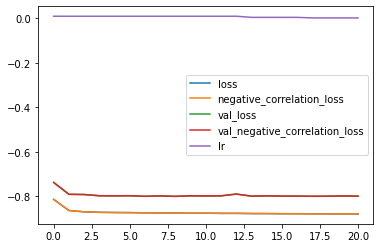

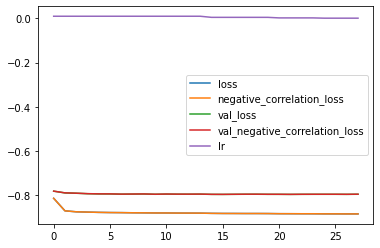

In [25]:
SUBMIT = True

# results
df_fold_score_stat_publ = pd.DataFrame();df_fold_score_stat_publ.index.name = 'dim_red_file'
df_fold_score_stat_priv = pd.DataFrame();df_fold_score_stat_priv.index.name = 'dim_red_file'


# Cross-validation
VERBOSE = 2 # set to 2 for more output
EPOCHS = 300

cv_idxs = list_folds_indices_by_days_and_donors_with2holdouts

np.random.seed(1)
tf.random.set_seed(1)

N_FOLDS = 2

core_list_train = []
score_list_priv = []
score_list_publ = []
va_pred_publ = []
va_pred_priv = []

X_file = '128tSVD+108important_raw_genes+210_connected_genes'


for fold in range(2): # N_FOLDS

    start_time = datetime.datetime.now()
    model = None
    gc.collect()

    X_tr_imp_genes, X_test_priv_imp_genes, X_test_publ_imp_genes, X_test_priv_imp_genes_holdout, X_test_publ_imp_genes_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_imp_genes, Y, cv_idxs)
    
    X_tr_dim_red, X_test_priv_dim_red, X_test_publ_dim_red, X_test_priv_dim_red_holdout, X_test_publ_dim_red_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_dim_red, Y, cv_idxs)
    
    X_tr_connect, X_test_priv_connect, X_test_publ_connect, X_test_priv_connect_holdout, X_test_publ_connect_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_connect, Y, cv_idxs)

    
    X_tr_dict = {'important_genes':X_tr_imp_genes, 'dim_reduced_genes':X_tr_dim_red, 'connect_genes':X_tr_connect}
    X_test_private_dict = {'important_genes':X_test_priv_imp_genes, 'dim_reduced_genes':X_test_priv_dim_red, 'connect_genes':X_test_priv_connect}
    X_test_publ_dict = {'important_genes':X_test_publ_imp_genes, 'dim_reduced_genes':X_test_publ_dim_red, 'connect_genes':X_test_publ_connect}
    

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                       patience=12, 
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]
    
    model = my_model(best_hp, n_inputs_imp_genes = X_tr_imp_genes.shape[1], n_inputs_dim_red= X_tr_dim_red.shape[1], n_inputs_connect= X_tr_connect.shape[1])
    
    history = model.fit(X_tr_dict, 
                         Y_train,
                         epochs = EPOCHS,
                         validation_data = (X_test_publ_dict, Y_test_publ),
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    if SUBMIT:
        model.save(f"/kaggle/temp/model_CNN_{fold}")
    history = history.history
    callbacks, lr = None, None
   
    
    # Print scores on trian to find if the model is overfitting
    y_tr_pred = model.predict(X_tr_dict, batch_size= len(X_tr_imp_genes)//100)
    corrscore = correlation_score(Y_train, y_tr_pred)
    core_list_train.append(corrscore)

    print(f"Fold {fold}: stopped after {es.stopped_epoch:3} epochs")
    print(f"   corr TRAIN=  {corrscore:.5f}")

    # We validate the model on PUBLIC
    y_va_pred = model.predict(X_test_publ_dict, batch_size=len(X_test_publ_imp_genes)//100)
    va_pred_publ.append(y_va_pred)
    corrscore = correlation_score(Y_test_publ, y_va_pred)

    print(f"   corr PUBLIC=  {corrscore:.5f}")
    score_list_publ.append(corrscore)
    df_fold_score_stat_publ.loc[X_file, f'FOLD_{str(fold)}'] = corrscore

    # We validate the model on PRIVATE
    y_va_pred = model.predict(X_test_private_dict, batch_size=len(X_test_priv_imp_genes)//100)
    va_pred_priv.append(y_va_pred)
    corrscore = correlation_score(Y_test_priv, y_va_pred)

    print(f"   corr PRIVATE=  {corrscore:.5f}")
    del es, Y_test_priv
    score_list_priv.append(corrscore)
    df_fold_score_stat_priv.loc[X_file, f'FOLD_{str(fold)}'] = corrscore
    
    pd.DataFrame(history).plot()


# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr PUBLIC = {np.array(score_list_publ).mean():.5f}{Style.RESET_ALL}")
print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr PRIVATE= {np.array(score_list_priv).mean():.5f}{Style.RESET_ALL}")

df_fold_score_stat_priv.loc[X_file, 'Average'] = np.array(score_list_priv).mean()
df_fold_score_stat_publ.loc[X_file, 'Average'] = np.array(score_list_publ).mean()

df_fold_score_stat_priv.to_csv('Fold_PRIVAT_scores_per_dim_reduction_table.csv')
df_fold_score_stat_publ.to_csv('Fold_PUBLIC_scores_per_dim_reduction_table.csv')


In [ ]:

if SUBMIT:
    test_pred_CNN = np.zeros((len(Xt), 140), dtype=np.float32)
    for fold in range(N_FOLDS):
        print(f"Predicting with fold {fold}")
        model = load_model(f"/kaggle/temp/model_CNN_{fold}",
                           custom_objects={'negative_correlation_loss': negative_correlation_loss})
        
#         Xt_imp_genes = Xt[:, -X0t.shape[1]:]
#         Xt_dim_red = Xt[:, :-X0t.shape[1]]

        
        
        test_pred_CNN += model.predict({'important_genes':X_test_imp_genes, 'dim_reduced_genes':X_test_dim_red, 'connect_genes':X_test_connect})
    
    test_pred = test_pred_CNN
    
    submission = pd.read_csv('../input/citeseq-keras-multiome-5x5/submission.csv',
                             index_col='row_id', squeeze=True)
    
    #submission = pd.read_csv('../input/multiome-quickstart-w-sparse-m-tsvd-32/submission.csv',
    #                         index_col='row_id', squeeze=True)
    
    submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
#     submission = std(submission)
    assert not submission.isna().any()
    submission.to_csv('submission.csv')
    display(submission)